# Project : Fake tweets with Response-Encdoing

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'18OnKZzKOkb3rZv_mgsvy6DP_z0bRVWHU'}) 
downloaded.GetContentFile('train.csv')

In [0]:
# For test file
download1 = drive.CreateFile({'id':'1rCir71bmCEDoEB9-4gXA8ZJxGjvx0DSk'})
downloaded.GetContentFile('test.csv')

In [0]:
# For Submission file
download2 = drive.CreateFile({'id':'1Mmx9ADQGtCzG93YwCil9idp0lPofDXdC'})
downloaded.GetContentFile('submission.csv')

In [95]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [96]:
!pip install scikit-plot

In [1]:
# importing the libaries

import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score , KFold
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report , confusion_matrix , f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix , roc_curve , accuracy_score , precision_score , recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB , GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam

import folium 
from folium import plugins

#from spellchecker import SpellChecker

Using TensorFlow backend.


In [2]:
# Load the train and test dataset

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

In [3]:
train.shape

(7613, 5)

In [4]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [6]:
new_train = train
new_train['keyword'].fillna("No keyword",inplace=True)
new_train.isnull().sum()

id             0
keyword        0
location    2533
text           0
target         0
dtype: int64

In [7]:
# drop the location column both from train and test part

# train.drop(['location'] , axis = 1 , inplace = True)
# test.drop(['location'] , axis = 1 , inplace = True)

In [8]:
train.shape

(7613, 5)

## EDA

Text(0, 0.5, 'Number of samples')

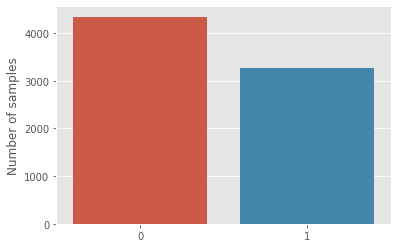

In [9]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('Number of samples')

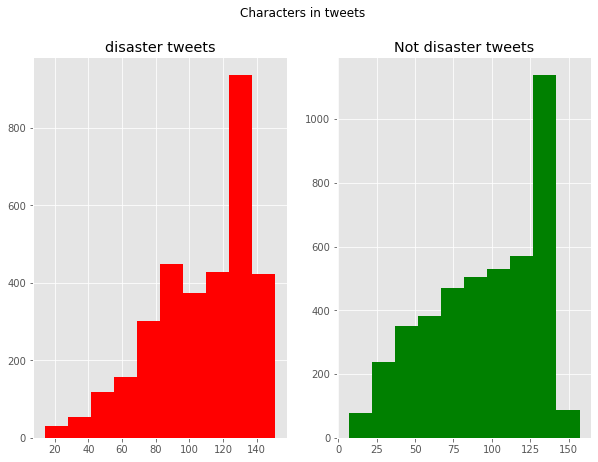

In [106]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

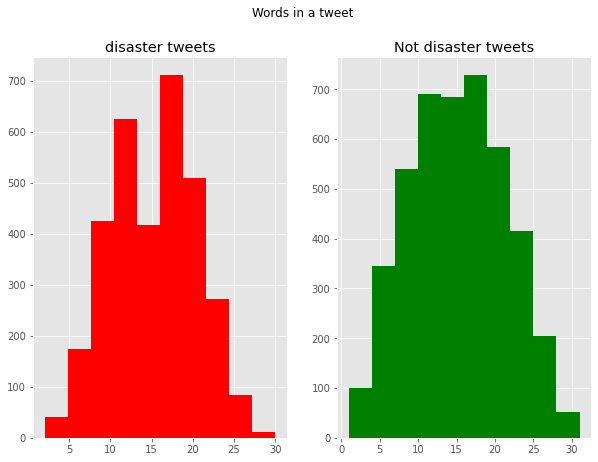

In [107]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

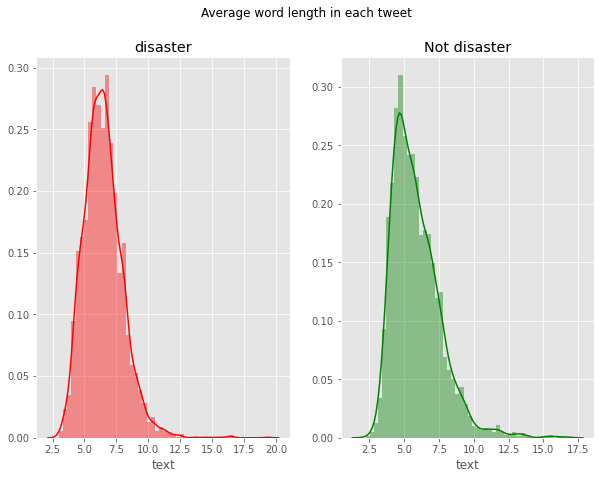

In [108]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [109]:
# Tweets per location

cnt_ = train['location'].value_counts()
cnt_.reset_index()
cnt_ = cnt_[:20,]
trace1 = go.Bar(
                x = cnt_.index,
                y = cnt_.values,
                name = "Number of tweets in dataset according to location",
                marker = dict(color = 'rgba(200, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )

data = [trace1]
layout = go.Layout(barmode = "group",title = 'Number of tweets depending on location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [110]:
#Number of tweets depending on location per class

train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]
cnt_1 = train1_df['location'].value_counts()
cnt_1.reset_index()
cnt_1 = cnt_1[:20,]

cnt_0 = train0_df['location'].value_counts()
cnt_0.reset_index()
cnt_0 = cnt_0[:20,]

trace1 = go.Bar(
                x = cnt_1.index,
                y = cnt_1.values,
                name = "Number of real disaster tweets",
                marker = dict(color = 'rgba(255, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )
trace0 = go.Bar(
                x = cnt_0.index,
                y = cnt_0.values,
                name = "Number of unreal disaster tweets",
                marker = dict(color = 'rgba(79, 82, 97, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )


data = [trace0,trace1]
layout = go.Layout(barmode = 'stack',title = 'Number of tweets depending on location per class')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

#### Visualize per location using map

In [111]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


df = train['location'].value_counts()[:20,]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['location', 'counts'] 
geolocator = Nominatim(user_agent="specify_your_app_name_here")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
dictt_latitude = {}
dictt_longitude = {}
for i in df['location'].values:
    print(i)
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude
df['latitude']= df['location'].map(dictt_latitude)
df['longitude'] = df['location'].map(dictt_longitude)

USA
New York
United States
London
Canada
Nigeria
UK
Los Angeles, CA
India
Mumbai
Washington, DC
Kenya
Worldwide
Chicago, IL
Australia
California
New York, NY
California, USA
Everywhere
Florida


In [112]:
map1 = folium.Map(location=[10.0, 10.0], tiles='CartoDB dark_matter', zoom_start=2.3)
markers = []
for i, row in df.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)
map1

It is clear that most of the tweets from america region.

#### Common Stopwords in tweets

In [0]:
def create_corpus(target):
    corpus =[]
    
    for x in train[train['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
            
    return corpus

In [0]:
corpus = create_corpus(1)

In [0]:
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top = sorted(dic.items(), key = lambda x:x[1] , reverse = True)[:10] 

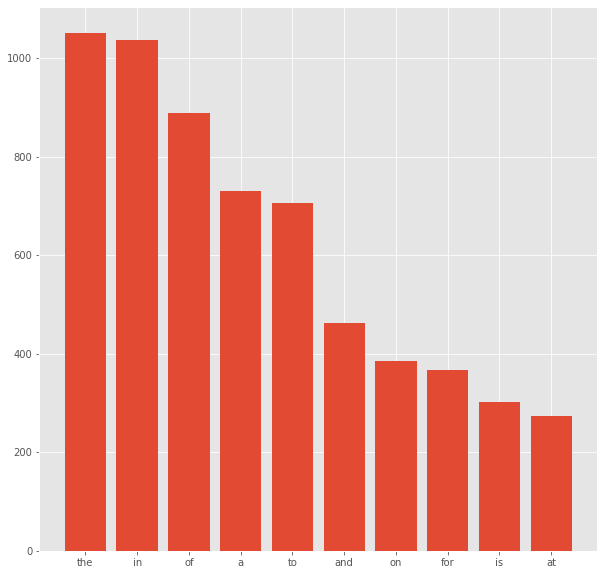

In [116]:
x , y = zip(*top)
plt.figure(figsize = (10 , 10))
plt.bar(x , y);

#### Analyzing Punctuations

<BarContainer object of 18 artists>

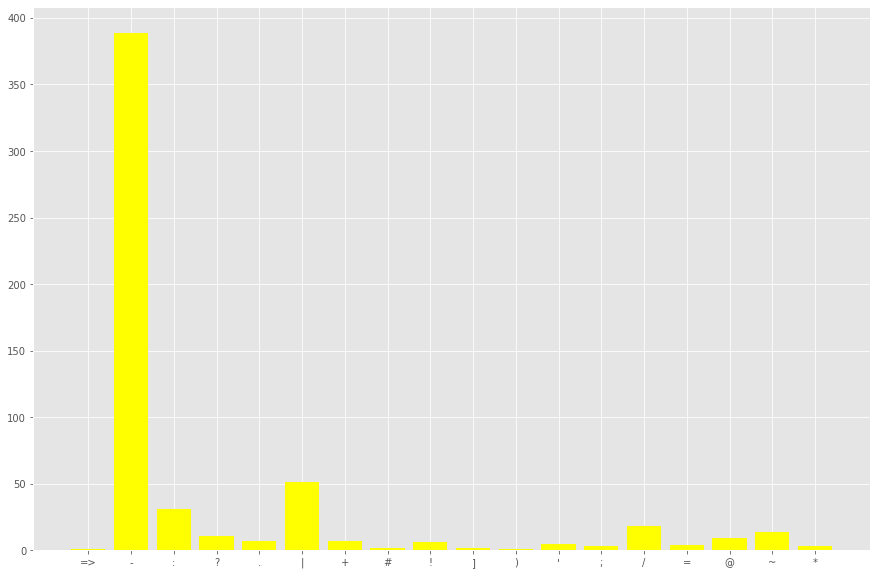

In [117]:
plt.figure(figsize=(15 , 10))

corpus = create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y , color = 'yellow')

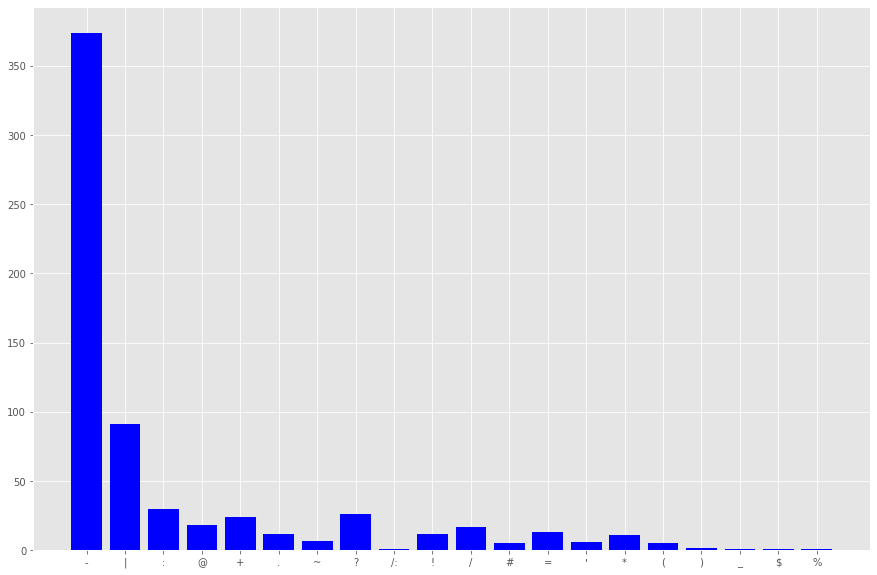

In [118]:
plt.figure(figsize=(15 , 10))
corpus = create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x , y , color = 'blue');

#### Common Words

In [0]:
counter=Counter(corpus)
most=counter.most_common()

x=[]
y=[]

for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

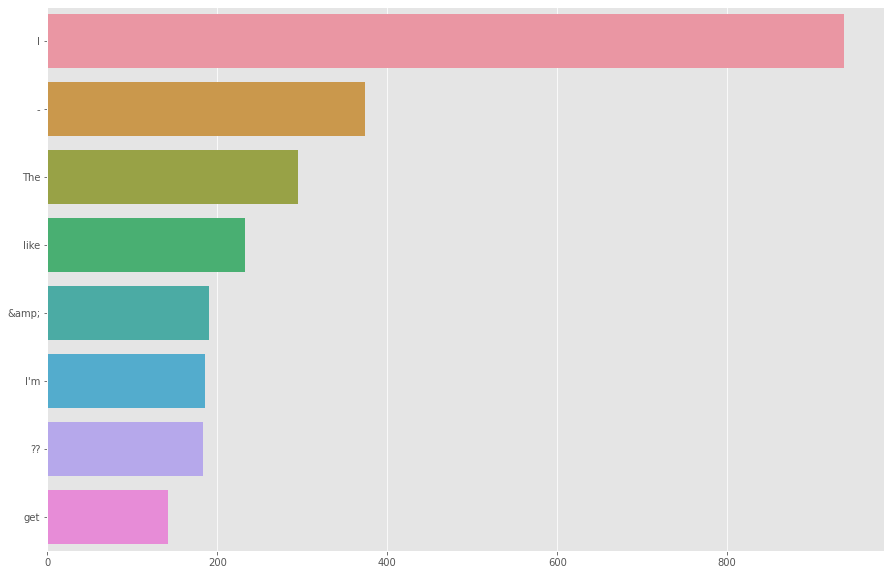

In [120]:
plt.figure(figsize=(15 , 10))
sns.barplot(x = y , y = x);

In [0]:
df = pd.concat([train , test])

## Data Preprocessing

1 . Removing stop words(Optional)

2 . Remove Punctuations

3 . Remove Html

4 . Remove Emojis

5 . Spelling Corrections

6 . Removing Urls

In [0]:
## Concate both train and test part
df_new = pd.concat([train , test])

In [123]:
df_new.shape

(15226, 5)

In [124]:
df_new.isnull().sum()

id             0
keyword       61
location    5066
text           0
target         0
dtype: int64

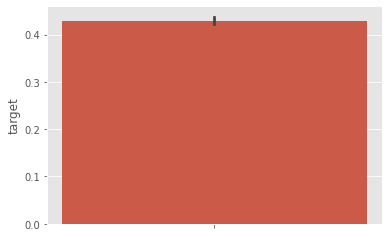

In [125]:
sns.barplot(y = 'target' , data = df_new)

In [126]:
df_new.head(20)

,id,keyword,location,text,target
0,1,No keyword,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,No keyword,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,No keyword,NaN,All residents asked to 'shelter in place' are ...,1
3,6,No keyword,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,No keyword,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,No keyword,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,No keyword,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,No keyword,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,No keyword,NaN,There's an emergency evacuation happening now ...,1
9,15,No keyword,NaN,I'm afraid that the tornado is coming to our a...,1


In [127]:
df_new.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [128]:
df_new['text'][0]

0    Our Deeds are the Reason of this #earthquake M...
0    Our Deeds are the Reason of this #earthquake M...
Name: text, dtype: object

In [129]:
df_new['text'][12]

12    #raining #flooding #Florida #TampaBay #Tampa 1...
12    #raining #flooding #Florida #TampaBay #Tampa 1...
Name: text, dtype: object

In [130]:
train['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

### Removing URLS

In [0]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [0]:
train['text'] = train['text'].apply(lambda x : remove_URL(x))
df_new['text'] = df_new['text'].apply(lambda x : remove_URL(x))
test['text'] = test['text'].apply(lambda x : remove_URL(x))

### Remove HTML tags

In [0]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [0]:
train['text'] = train['text'].apply(lambda x : remove_html(x))
test['text'] = test['text'].apply(lambda x : remove_html(x))
df_new['text'] = df_new['text'].apply(lambda x : remove_URL(x))

### Remove Emoji's

In [0]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [0]:
df_new['text']=df_new['text'].apply(lambda x: remove_emoji(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))

In [137]:
df_new['text'][12]

12    #raining #flooding #Florida #TampaBay #Tampa 1...
12    #raining #flooding #Florida #TampaBay #Tampa 1...
Name: text, dtype: object

### Remove Punctuations

In [0]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [0]:
df_new['text'] = df_new['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))

In [140]:
df_new['text'][12]

12    raining flooding Florida TampaBay Tampa 18 or ...
12    raining flooding Florida TampaBay Tampa 18 or ...
Name: text, dtype: object

In [141]:
train['text'][12]

'raining flooding Florida TampaBay Tampa 18 or 19 days Ive lost count '

In [142]:
train.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,No keyword,NaN,Forest fire near La Ronge Sask Canada,1
2,5,No keyword,NaN,All residents asked to shelter in place are be...,1
3,6,No keyword,NaN,13000 people receive wildfires evacuation orde...,1
4,7,No keyword,NaN,Just got sent this photo from Ruby Alaska as s...,1


In [143]:
train.tail()

,id,keyword,location,text,target
7608,10869,No keyword,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,No keyword,NaN,ariaahrary TheTawniest The out of control wild...,1
7610,10871,No keyword,NaN,M194 0104 UTC5km S of Volcano Hawaii,1
7611,10872,No keyword,NaN,Police investigating after an ebike collided w...,1
7612,10873,No keyword,NaN,The Latest More Homes Razed by Northern Califo...,1


### Spelling corrections

In [0]:
# spell = SpellChecker()
# def correct_spellings(text):
#     corrected_text = []
#     misspelled_words = spell.unknown(text.split())
#     for word in text.split():
#         if word in misspelled_words:
#             corrected_text.append(spell.correction(word))
#         else:
#             corrected_text.append(word)
#     return " ".join(corrected_text)

In [0]:
# df_new['text'] = df_new['text'].apply(lambda x : correct_spellings(x))
# train['text'] = train['text'].apply(lambda x : correct_spellings(x))

In [146]:
train.tail()

,id,keyword,location,text,target
7608,10869,No keyword,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,No keyword,NaN,ariaahrary TheTawniest The out of control wild...,1
7610,10871,No keyword,NaN,M194 0104 UTC5km S of Volcano Hawaii,1
7611,10872,No keyword,NaN,Police investigating after an ebike collided w...,1
7612,10873,No keyword,NaN,The Latest More Homes Razed by Northern Califo...,1


In [147]:
df_new.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,No keyword,NaN,Forest fire near La Ronge Sask Canada,1
2,5,No keyword,NaN,All residents asked to shelter in place are be...,1
3,6,No keyword,NaN,13000 people receive wildfires evacuation orde...,1
4,7,No keyword,NaN,Just got sent this photo from Ruby Alaska as s...,1


## Convert Text to Response-Encdoing

In [0]:
x = train.drop(['keyword' , 'location' , 'target'] , axis = 1)
y = train['target']

In [149]:
x

,id,text
0,1,Our Deeds are the Reason of this earthquake Ma...
1,4,Forest fire near La Ronge Sask Canada
2,5,All residents asked to shelter in place are be...
3,6,13000 people receive wildfires evacuation orde...
4,7,Just got sent this photo from Ruby Alaska as s...
...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...
7609,10870,ariaahrary TheTawniest The out of control wild...
7610,10871,M194 0104 UTC5km S of Volcano Hawaii
7611,10872,Police investigating after an ebike collided w...


In [150]:
test

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,ariaahrary TheTawniest The out of control wild...,1
7610,10871,NaN,NaN,M194 0104 UTC5km S of Volcano Hawaii,1
7611,10872,NaN,NaN,Police investigating after an ebike collided w...,1


In [151]:
final_test = test.drop(['keyword' , 'location'] , axis = 1)
final_test

,id,text,target
0,1,Our Deeds are the Reason of this earthquake Ma...,1
1,4,Forest fire near La Ronge Sask Canada,1
2,5,All residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,Just got sent this photo from Ruby Alaska as s...,1
...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1
7609,10870,ariaahrary TheTawniest The out of control wild...,1
7610,10871,M194 0104 UTC5km S of Volcano Hawaii,1
7611,10872,Police investigating after an ebike collided w...,1


In [152]:
final_test.shape

(7613, 3)

In [0]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.20 , random_state = 78)

In [154]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(6090, 2)
(1523, 2)
(6090,)


### response-encoding on Text


In [0]:
new_train = train

In [0]:
text_vectorizer = CountVectorizer(min_df = 3)
train_text_onehotencoding = text_vectorizer.fit_transform(x_train['text'])
train_text_features = text_vectorizer.get_feature_names()

In [0]:
#Find the unique word and save it on a dict.
def extract_dict(cls_text):
    dictionary = defaultdict(int)
    for index , row in cls_text.iterrows():
        for word in row['text'].split():
            dictionary[word] += 1
    return dictionary

In [0]:
import math

def get_text_ResponseCoding(df):
    text_feature_responsecoding = np.zeros((df.shape[0] , 9))
    for i in range(0 , 9):
        row_index = 0
        for index , row in df.iterrows():
            sum_prb = 0
            for word in row['text'].split():
                sum_prb += math.log(((dict_list[i].get(word , 0) + 10)/(total_dict.get(word , 0)+90)))
            
            text_feature_responsecoding[row_index][i] = math.exp(sum_prb/len(row['text'].split()))
            row_index += 1
            
    return text_feature_responsecoding

In [0]:
dict_list = []

for i in range(1, 10):
    cls_text = new_train[new_train['target'] == i]
    dict_list.append(extract_dict(cls_text))
    
#total_dict build on whole training data.
total_dict = extract_dict(new_train)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0 , 9):
        ratios.append((dict_list[j][i] + 10) / (total_dict[i] + 90))
    confuse_array.append(ratios)
    
confuse_array = np.array(confuse_array)    

In [0]:
#response coding of text features
x_train_text_responseCoding  = get_text_ResponseCoding(x_train)
x_test_text_responseCoding  = get_text_ResponseCoding(x_test)
test_text_responseCoding  = get_text_ResponseCoding(final_test)

In [161]:
x_train_text_responseCoding.shape

(6090, 9)

In [162]:
test_text_responseCoding.shape

(7613, 9)

In [163]:
test_text_responseCoding

array([[0.21239976, 0.04407216, 0.04407216, ..., 0.04407216, 0.04407216,
        0.04407216],
       [0.2257723 , 0.08251912, 0.08251912, ..., 0.08251912, 0.08251912,
        0.08251912],
       [0.23488413, 0.04788745, 0.04788745, ..., 0.04788745, 0.04788745,
        0.04788745],
       ...,
       [0.21040037, 0.06509947, 0.06509947, ..., 0.06509947, 0.06509947,
        0.06509947],
       [0.22154806, 0.05655769, 0.05655769, ..., 0.05655769, 0.05655769,
        0.05655769],
       [0.38308387, 0.05456682, 0.05456682, ..., 0.05456682, 0.05456682,
        0.05456682]])

In [164]:
x_test_text_responseCoding.shape

(1523, 9)

In [0]:
# count_vect = CountVectorizer()
# X_train_BOW = count_vect.fit_transform(x_train['text'])
# X_test_BOW = count_vect.transform(x_test['text'])
# test_BOW = count_vect.transform(test['text'])

In [166]:
print("**Response-Encoding**")
print("="*50)


print(x_train_text_responseCoding.shape)
print(x_test_text_responseCoding.shape)
print(test_text_responseCoding.shape)

**Response-Encoding**
(6090, 9)
(1523, 9)
(7613, 9)


## Apply DIfferent ML model on Response-Encdoing

## Logistic Regression on Response-Encdoing

In [0]:
#Standardising the train and test data

sc = StandardScaler(copy = True , with_mean = False , with_std = True)
X_train = sc.fit_transform(x_train_text_responseCoding)
X_test = sc.transform(x_test_text_responseCoding)
Test = sc.transform(test_text_responseCoding)

In [168]:
tuned_parameters = [10**-4, 10**-2, 10**0, 10**2, 10**4]

cv_scores = []

for i in tqdm(tuned_parameters):
    model = LogisticRegression(penalty = 'l1' , C = i , n_jobs = -1)
    scores = cross_val_score(model , X_train , y_train , cv = 10 , scoring = 'accuracy' , n_jobs = -1)
    cv_scores.append(scores.mean())

100%|██████████| 5/5 [00:00<00:00, 25.69it/s]


In [169]:
optimal_C = tuned_parameters[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of C is %.3f.' % optimal_C)


The optimal value of C is 0.000.


In [170]:
lr = LogisticRegression(penalty = 'l2' , C = 0.0001 , n_jobs = -1)
lr.fit(X_train , y_train)
pred = lr.predict(X_test)

ac = accuracy_score(y_test , pred)
print(ac*100)

62.9021667760998


***Test Data Report***
Best C =  0.0001
AUC =  54.727564102564095


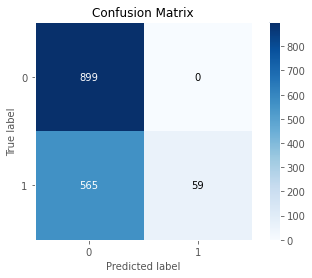

In [171]:
from sklearn import metrics
import scikitplot as skplt

print("***Test Data Report***")
print("Best C = ",optimal_C)
fpr, tpr, threshold = roc_curve(y_test , lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [0]:
fpr, tpr, threshold = metrics.roc_curve(y_test , lr.predict(X_test))
fpr2, tpr2, threshold2 = metrics.roc_curve(y_test , lr.predict(X_test))

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

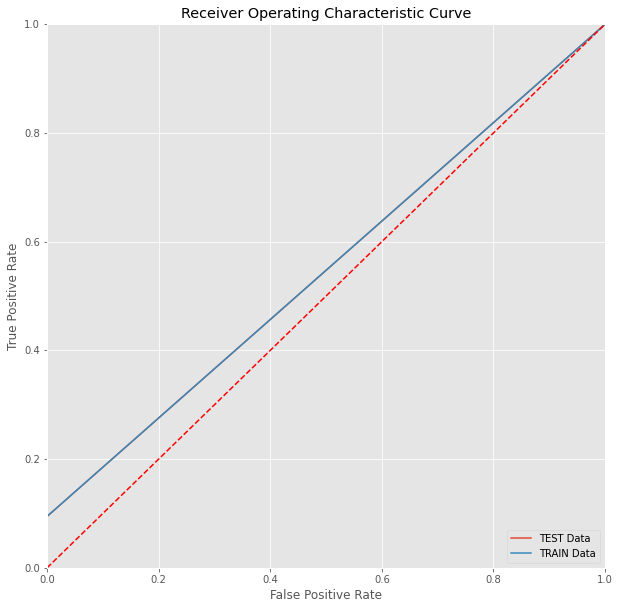

In [173]:
# plot ROC-curve
plt.figure(figsize = (10 , 10))
plt.title('Receiver Operating Characteristic Curve')
plt.gca()
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
# feature_name = count_vect.get_feature_names()
# w = lr.coef_
# weight=w.reshape(-1)
# sorted_feature = np.argsort(weight)
# top_20_positive_feature=sorted_feature[:-20:-1]

In [0]:
# print("Positive feature top 20 :")
# print("-------")
# for i in top_20_positive_feature:
#     print("%s\t-->\t%f"%(feature_name[i],weight[i]))

In [0]:
# w = lr.coef_
# weight=w.reshape(-1)
# sorted_feature = np.argsort(weight)
# feature_name = count_vect.get_feature_names()
# top_20_negative_feature = sorted_feature[:20]

In [0]:
# print("Negative feature top 20 :")
# print("-------")
# for i in top_20_negative_feature:
#     print("%s\t -->\t%f  "%(feature_name[i],weight[i]))

In the above list it is clear that there are so many stop words that affects our model.we have to remove the stopwords.

## Apply KNN on Response-Encdoing

In [178]:
knn = KNeighborsClassifier()
knn.fit(X_train , y_train)

y_pred_knn = knn.predict(X_test)

ac = accuracy_score(y_test , y_pred_knn)
print(ac*100)

80.56467498358502


In [0]:
n_folds = 5
parameters = {
        'n_neighbors': range (2 , 50 , 2)
        }


In [180]:
knn = KNeighborsClassifier()

tree = GridSearchCV(estimator = knn , param_grid = parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)
tree.fit(X_train , y_train)

score1 = tree.cv_results_

print(pd.DataFrame(score1).head())
print(tree.best_params_)

   mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       0.009751      0.001357  ...          0.876190         0.002801
1       0.009272      0.001273  ...          0.854023         0.002617
2       0.009382      0.001313  ...          0.844212         0.002362
3       0.010433      0.002028  ...          0.839122         0.002367
4       0.008856      0.000071  ...          0.836207         0.002497

[5 rows x 21 columns]
{'n_neighbors': 38}


In [181]:
score1 = pd.DataFrame(score1)
score1.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.009751,0.001357,0.060986,0.001553,2,{'n_neighbors': 2},0.779967,0.768473,0.769294,0.767652,0.773399,0.771757,0.004556,24,0.873358,0.878079,0.873974,0.880747,0.874795,0.876190,0.002801
1,0.009272,0.001273,0.059565,0.001701,4,{'n_neighbors': 4},0.795567,0.781609,0.788998,0.788177,0.789819,0.788834,0.004449,23,0.853243,0.858990,0.853243,0.853448,0.851190,0.854023,0.002617
2,0.009382,0.001313,0.063108,0.001643,6,{'n_neighbors': 6},0.808703,0.795567,0.811166,0.805419,0.802956,0.804762,0.005381,22,0.844417,0.848727,0.842570,0.842775,0.842570,0.844212,0.002362
3,0.010433,0.002028,0.064318,0.001811,8,{'n_neighbors': 8},0.811987,0.798851,0.814450,0.805419,0.809524,0.808046,0.005481,21,0.837438,0.843596,0.837028,0.838259,0.839286,0.839122,0.002367
4,0.008856,0.000071,0.064319,0.001719,10,{'n_neighbors': 10},0.817734,0.798851,0.811166,0.811166,0.813629,0.810509,0.006304,18,0.838465,0.838054,0.836823,0.836207,0.831486,0.836207,0.002497


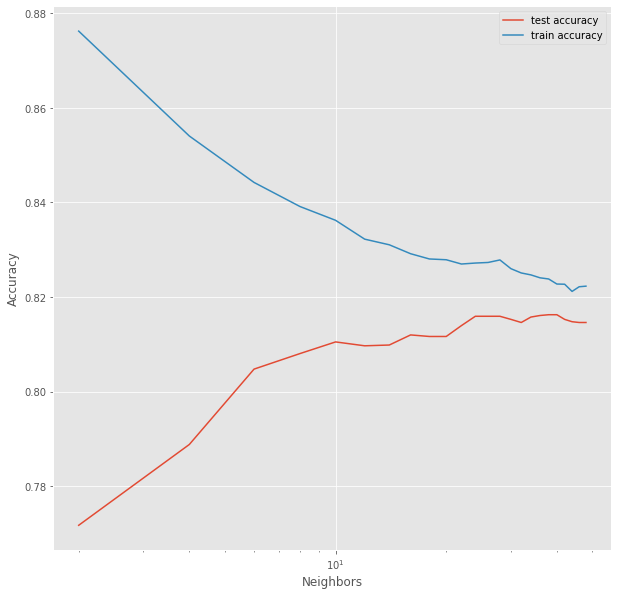

In [182]:
plt.figure(figsize=(10 , 10))
plt.plot(score1['param_n_neighbors'], score1['mean_test_score'])
plt.plot(score1['param_n_neighbors'], score1['mean_train_score'])
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'] , loc='upper right')
plt.xscale('log')

In [183]:
knn = KNeighborsClassifier(n_neighbors = 38 , algorithm = 'kd_tree')
knn.fit(X_train , y_train)

y_pred_knn = knn.predict(X_test)

ac_knn = accuracy_score(y_test , y_pred_knn)
print('After Cross-validation: ',ac*100)

After Cross-validation:  80.56467498358502


In [0]:
# test_pred = knn.predict(Test)

# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission01knn.csv', index=False)

## Naive-Bayes on Response-Encdoing

In [185]:
alpha = [] 
i = 0.001

while(i <= 1000):
    alpha.append(np.round(i,3))
    i *= 3

cv_scores = []

for k in tqdm(alpha):
    model = MultinomialNB(alpha = k)
    scores = cross_val_score(model , X_train , y_train , cv = 10 , scoring = 'f1_macro' , n_jobs = -1)
    cv_scores.append(scores.mean()) 

100%|██████████| 13/13 [00:00<00:00, 17.85it/s]


In [186]:
optimal_alpha = alpha[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 177.147.


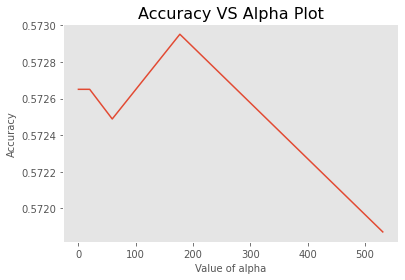


*******Train Data Report******

Alpha values :
 [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

F1 Score for each value of alpha :
  [57.265 57.265 57.265 57.265 57.265 57.265 57.265 57.265 57.265 57.265
 57.249 57.295 57.187]


In [187]:
# plot accuracy vs alpha 
plt.plot(alpha, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha Plot',size=16)
plt.grid()
plt.show()
print("\n*******Train Data Report******");
print("\nAlpha values :\n",alpha)
print("\nF1 Score for each value of alpha :\n ", np.round(cv_scores,5)*100)

In [0]:
model_bow_multinomial = MultinomialNB(alpha = optimal_alpha)

model_bow_multinomial.fit(X_train , y_train)

pred = model_bow_multinomial.predict(X_test)

***Test Data Report***
Accuracy =  63.03348653972422
f1_score =  57.98353052439184
precision_score =  61.40217879604673
recall_score =  58.687002652519894


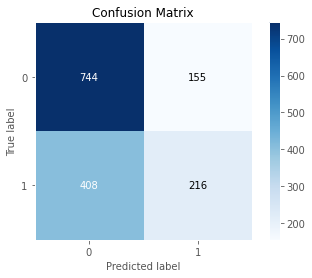

In [189]:
print("***Test Data Report***")
print('Accuracy = ', accuracy_score(y_test, pred)*100)
print("f1_score = ",f1_score(y_test, pred, average='macro')*100)

print("precision_score = " , precision_score(y_test , pred, average='macro')*100)
print("recall_score = " , recall_score(y_test, pred, average='macro')*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)

plt.show()

In [190]:
print(classification_report(y_test , pred))

              precision    recall  f1-score   support

           0       0.65      0.83      0.73       899
           1       0.58      0.35      0.43       624

    accuracy                           0.63      1523
   macro avg       0.61      0.59      0.58      1523
weighted avg       0.62      0.63      0.61      1523



## SVM on Response-Encdoing

In [191]:
sv = SVC()
sv.fit(X_train , y_train)

y_pred_svm = sv.predict(X_test)

ac_svr = accuracy_score(y_test , y_pred_svm)
print(ac_svr*100)

82.9940906106369


In [192]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
params = {"C": [0.01 , 0.1, 1, 10 , 100, 1000]}

model = SVC()

model_cv_C = GridSearchCV(estimator = model, param_grid = params, cv = folds , verbose = 1 , return_train_score=True , n_jobs = -1)
model_cv_C.fit(X_train, y_train) 


cv_results = pd.DataFrame(model_cv_C.cv_results_)
cv_results

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   31.3s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.250047,0.044449,0.235545,0.007157,0.01,{'C': 0.01},0.751232,0.712644,0.761084,0.766010,0.724959,0.743186,0.020838,6,0.744458,0.746511,0.746921,0.741995,0.740969,0.744171,0.002371
1,0.882563,0.015026,0.166134,0.001663,0.1,{'C': 0.1},0.807061,0.788998,0.816913,0.802956,0.799672,0.803120,0.009134,5,0.804187,0.805829,0.802545,0.806445,0.804598,0.804721,0.001359
2,0.772998,0.007505,0.138870,0.001757,1,{'C': 1},0.816913,0.812808,0.833333,0.814450,0.809524,0.817406,0.008318,4,0.819787,0.818350,0.817939,0.819992,0.820197,0.819253,0.000923
3,0.785304,0.009388,0.132020,0.003289,10,{'C': 10},0.822660,0.811987,0.831691,0.818555,0.812808,0.819540,0.007221,1,0.818966,0.821634,0.818966,0.821223,0.822250,0.820608,0.001380
4,1.144182,0.053998,0.129889,0.003208,100,{'C': 100},0.821839,0.812808,0.826765,0.817734,0.810345,0.817898,0.005952,3,0.820813,0.820813,0.818555,0.822865,0.822865,0.821182,0.001603
5,2.811786,0.233081,0.121283,0.023160,1000,{'C': 1000},0.817734,0.818555,0.829228,0.820197,0.811166,0.819376,0.005805,2,0.819581,0.821223,0.819171,0.822250,0.822865,0.821018,0.001446


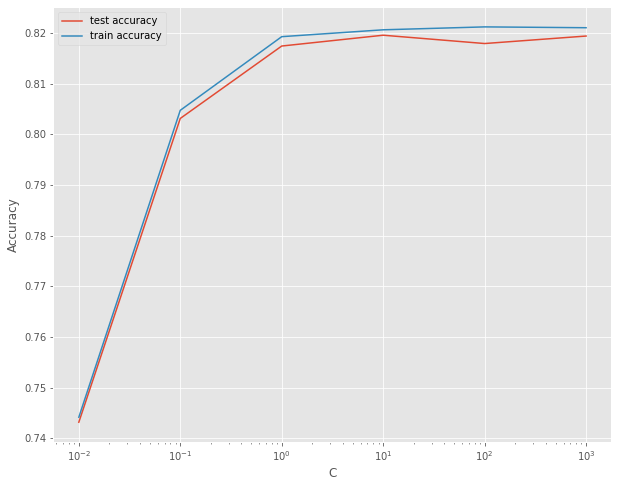

In [193]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [194]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
gamma = {'gamma': [1, 0.1, 0.01, 0.001, 0.0001 , 1.1 , 1.3]}

model = SVC()

model_cv_g = GridSearchCV(estimator = model, param_grid = gamma, cv = folds , verbose = 1 , return_train_score=True ,  n_jobs = -1)
model_cv_g.fit(X_train, y_train) 

cv_results_g = pd.DataFrame(model_cv_g.cv_results_)
cv_results_g

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   30.9s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.850120,0.015411,0.124143,0.001572,1,{'gamma': 1},0.818555,0.814450,0.830870,0.817734,0.810345,0.818391,0.006877,1,0.820813,0.821429,0.818144,0.821018,0.823071,0.820895,0.001588
1,0.796265,0.011074,0.135886,0.005035,0.1,{'gamma': 0.1},0.816913,0.813629,0.833333,0.813629,0.809524,0.817406,0.008302,4,0.819787,0.817734,0.817939,0.819992,0.819992,0.819089,0.001027
2,0.858474,0.015911,0.151726,0.002294,0.01,{'gamma': 0.01},0.815271,0.801314,0.827586,0.815271,0.804598,0.812808,0.009274,5,0.814450,0.814450,0.811576,0.813629,0.813218,0.813465,0.001058
3,1.066197,0.016952,0.203777,0.003238,0.001,{'gamma': 0.001},0.780788,0.753695,0.803777,0.795567,0.770936,0.780952,0.017764,6,0.784483,0.782635,0.780172,0.781404,0.782225,0.782184,0.001424
4,1.390228,0.016367,0.262830,0.005665,0.0001,{'gamma': 0.0001},0.619869,0.567323,0.628079,0.628079,0.581281,0.604926,0.025567,7,0.602217,0.610837,0.595443,0.605090,0.607143,0.604146,0.005179
5,0.823652,0.019315,0.130298,0.002080,1.1,{'gamma': 1.1},0.816913,0.814450,0.830049,0.817734,0.810345,0.817898,0.006597,2,0.820402,0.820197,0.818760,0.820402,0.822455,0.820443,0.001178
6,0.808449,0.039356,0.122287,0.021346,1.3,{'gamma': 1.3},0.816092,0.816092,0.830870,0.815271,0.809524,0.817570,0.007089,3,0.819581,0.821223,0.818350,0.822044,0.824097,0.821059,0.001987


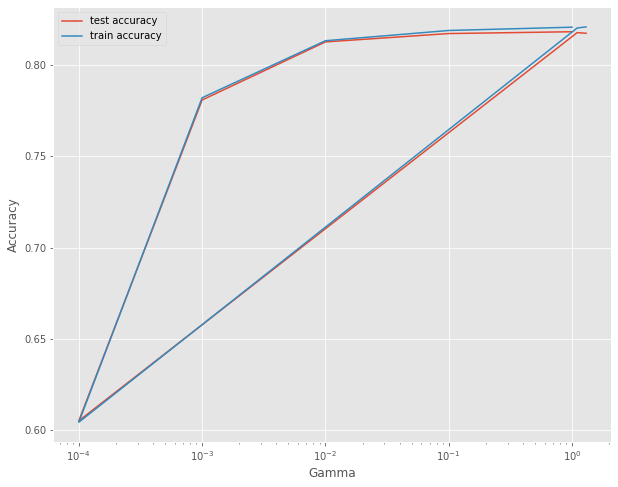

In [195]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_g['param_gamma'], cv_results_g['mean_test_score'])
plt.plot(cv_results_g['param_gamma'], cv_results_g['mean_train_score'])
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [196]:
print(model_cv_C.best_params_)
print(model_cv_g.best_params_)

{'C': 10}
{'gamma': 1}


In [0]:
sv = SVC(C = 10 , gamma = 1)
sv.fit(X_train , y_train)

y_pred_svm = sv.predict(X_test)

ac_svr = accuracy_score(y_test , y_pred_svm)
print(ac_svr*100)

In [0]:
# test_pred = xg_model.predict(Test)

# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission05xgb.csv', index=False)

In [198]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
auc_score=[]


for i in tqdm(alpha):
    model = linear_model.SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')
    model.fit(X_train, y_train)
    
    Cal_CV_model = CalibratedClassifierCV(model, method="sigmoid",cv=10)
    Cal_CV_model.fit(X_train, y_train)
    predict_y = Cal_CV_model.predict_proba(X_train)
    preds = predict_y[:,1]
    roc_auc = roc_auc_score(y_train, preds)
    auc_score.append(roc_auc)

100%|██████████| 9/9 [00:02<00:00,  3.61it/s]


In [0]:
# determining best value of alpha
optimal_alpha = alpha[auc_score.index(max(auc_score))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)

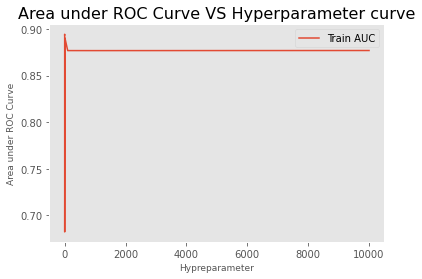

In [199]:
# plot accuracy vs alpha 
plt.plot(alpha, auc_score,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best alpha =  177.147
AUC =  78.89811685348393


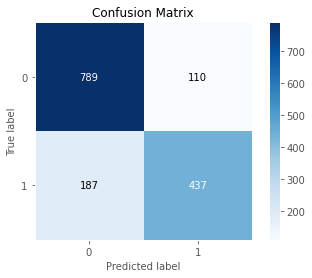

In [200]:
model = linear_model.SGDClassifier(alpha=optimal_alpha, loss='hinge', class_weight='balanced')
model.fit(X_train, y_train)

lr = CalibratedClassifierCV(model, method="sigmoid",cv=10)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best alpha = ",optimal_alpha)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

## Decision Tree on Response-Encdoing

In [201]:
dt = DecisionTreeClassifier()
dt.fit(X_train , y_train)


y_pred_dt = dt.predict(X_test)

ac = accuracy_score(y_test , y_pred_dt)
print(ac*100)

75.96848325673014


In [202]:
n_folds = 5
parameters = {'min_samples_split': range(20 , 200 , 20)}

dtree = DecisionTreeClassifier(random_state = 100)

tree_split = GridSearchCV(dtree, parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_split.fit(X_train, y_train)


cv_results_ms = pd.DataFrame(tree_split.cv_results_)
cv_results_ms

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.061368,0.005219,0.001357,0.000829,20,{'min_samples_split': 20},0.757800,0.791461,0.790640,0.790640,0.784072,0.782923,0.012842,9,0.890599,0.896962,0.891626,0.898810,0.893678,0.894335,0.003119
1,0.056355,0.003758,0.000974,0.000073,40,{'min_samples_split': 40},0.773399,0.807061,0.802135,0.799672,0.810345,0.798522,0.013101,8,0.864943,0.866995,0.868021,0.871305,0.867200,0.867693,0.002071
2,0.056988,0.006039,0.001068,0.000080,60,{'min_samples_split': 60},0.792282,0.811987,0.807882,0.804598,0.816092,0.806568,0.008121,7,0.853859,0.857348,0.853038,0.853859,0.850575,0.853736,0.002171
3,0.052155,0.001309,0.001103,0.000086,80,{'min_samples_split': 80},0.790640,0.818555,0.808703,0.810345,0.816092,0.808867,0.009803,5,0.847701,0.852011,0.847701,0.847496,0.843596,0.847701,0.002664
4,0.048878,0.001476,0.001010,0.000092,100,{'min_samples_split': 100},0.788998,0.816913,0.807882,0.817734,0.818555,0.810016,0.011192,2,0.838875,0.843801,0.836002,0.837233,0.834565,0.838095,0.003186
5,0.047715,0.002725,0.001004,0.000087,120,{'min_samples_split': 120},0.790640,0.821018,0.803777,0.819376,0.809524,0.808867,0.011105,5,0.833128,0.838259,0.831691,0.835591,0.826149,0.832964,0.004075
6,0.043801,0.001348,0.000903,0.000090,140,{'min_samples_split': 140},0.788998,0.822660,0.809524,0.821839,0.803777,0.809360,0.012477,4,0.826765,0.833128,0.828818,0.833744,0.824302,0.829351,0.003634
7,0.042609,0.000307,0.000922,0.000063,160,{'min_samples_split': 160},0.799672,0.816092,0.810345,0.820197,0.803777,0.810016,0.007571,2,0.824918,0.828818,0.828612,0.830049,0.824302,0.827340,0.002291
8,0.038479,0.005002,0.000862,0.000117,180,{'min_samples_split': 180},0.801314,0.812808,0.811987,0.820197,0.804598,0.810181,0.006638,1,0.824097,0.826560,0.826355,0.825123,0.823686,0.825164,0.001157


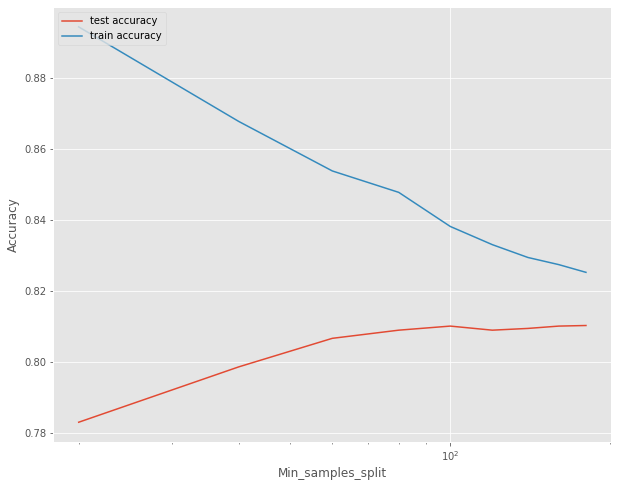

In [203]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_ms['param_min_samples_split'] , cv_results_ms['mean_test_score'])
plt.plot(cv_results_ms['param_min_samples_split'] , cv_results_ms['mean_train_score'])
plt.xlabel('Min_samples_split')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [204]:
n_folds = 5
parameters = {'min_samples_leaf': range (1 , 20)}

dtree = DecisionTreeClassifier()

tree_ml = GridSearchCV(dtree , parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_ml.fit(X_train, y_train)


cv_results_ml = pd.DataFrame(tree_ml.cv_results_)
cv_results_ml

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.066531,0.003453,0.001201,0.000153,1,{'min_samples_leaf': 1},0.770936,0.748768,0.751232,0.770115,0.769294,0.762069,0.009899,19,0.991174,0.992406,0.990148,0.991174,0.990558,0.991092,0.000764
1,0.060120,0.003249,0.001052,0.000070,2,{'min_samples_leaf': 2},0.773399,0.763547,0.760263,0.779967,0.773399,0.770115,0.007195,18,0.938424,0.939039,0.931650,0.936371,0.936782,0.936453,0.002598
2,0.058970,0.001853,0.000933,0.000049,3,{'min_samples_leaf': 3},0.768473,0.772578,0.765189,0.787356,0.771757,0.773071,0.007607,17,0.919335,0.919540,0.917488,0.915435,0.915025,0.917365,0.001888
3,0.058569,0.002616,0.001001,0.000082,4,{'min_samples_leaf': 4},0.766831,0.772578,0.773399,0.787356,0.781609,0.776355,0.007244,16,0.899425,0.898399,0.898194,0.894704,0.895936,0.897332,0.001739
4,0.058484,0.003484,0.001042,0.000085,5,{'min_samples_leaf': 5},0.773399,0.785714,0.782430,0.790640,0.791461,0.784729,0.006556,15,0.887726,0.889778,0.887521,0.888957,0.887315,0.888259,0.000950
5,0.058314,0.002831,0.001181,0.000085,6,{'min_samples_leaf': 6},0.780788,0.785714,0.775041,0.802956,0.795567,0.788013,0.010061,14,0.876437,0.878900,0.876232,0.876847,0.877874,0.877258,0.000997
6,0.055087,0.002890,0.000986,0.000073,7,{'min_samples_leaf': 7},0.783251,0.788177,0.784072,0.811987,0.793924,0.792282,0.010553,13,0.870895,0.874179,0.872742,0.871921,0.872537,0.872455,0.001075
7,0.055712,0.002369,0.000973,0.000073,8,{'min_samples_leaf': 8},0.789819,0.805419,0.790640,0.806240,0.788998,0.796223,0.007865,12,0.865558,0.868227,0.868021,0.868021,0.866585,0.867282,0.001043
8,0.051639,0.002028,0.000914,0.000060,9,{'min_samples_leaf': 9},0.786535,0.807882,0.791461,0.811987,0.790640,0.797701,0.010210,10,0.862890,0.865353,0.863095,0.864943,0.862274,0.863711,0.001211
9,0.051080,0.002012,0.000985,0.000044,10,{'min_samples_leaf': 10},0.789819,0.812808,0.794745,0.811166,0.799672,0.801642,0.009018,7,0.860427,0.862890,0.860222,0.862890,0.858785,0.861043,0.001611


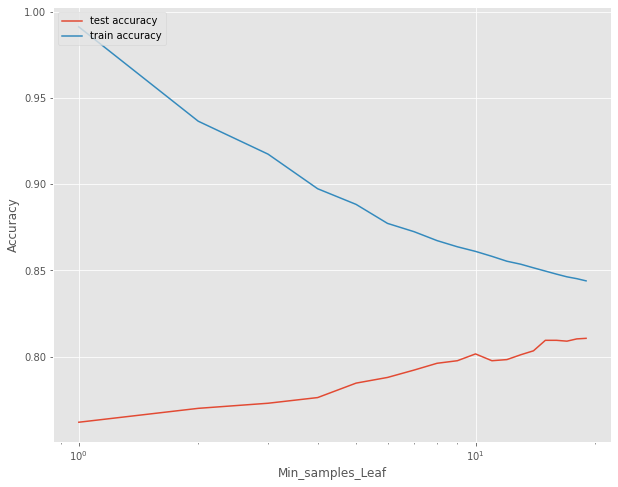

In [205]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_ml['param_min_samples_leaf'] , cv_results_ml['mean_test_score'])
plt.plot(cv_results_ml['param_min_samples_leaf'] , cv_results_ml['mean_train_score'])
plt.xlabel('Min_samples_Leaf')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [206]:
n_folds = 5
parameters = {'max_depth':range (1,20)}

dtree = DecisionTreeClassifier()

tree_d = GridSearchCV(dtree , parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_d.fit(X_train, y_train)


cv_results_d = pd.DataFrame(tree_d.cv_results_)
cv_results_d

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.012226,0.002274,0.000921,0.000101,1,{'max_depth': 1},0.727422,0.715107,0.708539,0.738095,0.717570,0.721346,0.010341,19,0.719828,0.728654,0.724138,0.724548,0.729680,0.725369,0.003529
1,0.020884,0.002975,0.000871,0.000050,2,{'max_depth': 2},0.727422,0.739737,0.708539,0.748768,0.736453,0.732184,0.013654,18,0.719828,0.747332,0.724138,0.743021,0.746100,0.736084,0.011679
2,0.028501,0.003168,0.000873,0.000052,3,{'max_depth': 3},0.784072,0.780788,0.763547,0.806240,0.788177,0.784565,0.013705,8,0.790846,0.796182,0.791667,0.791256,0.791872,0.792365,0.001941
3,0.029926,0.000195,0.000867,0.000076,4,{'max_depth': 4},0.789819,0.781609,0.790640,0.800493,0.785714,0.789655,0.006304,6,0.804598,0.797414,0.808498,0.796388,0.796182,0.800616,0.005015
4,0.035703,0.000384,0.000863,0.000014,5,{'max_depth': 5},0.791461,0.812808,0.785714,0.819376,0.811987,0.804269,0.013183,3,0.822044,0.825534,0.810961,0.821839,0.820813,0.820238,0.004905
5,0.041673,0.003148,0.000885,0.000037,6,{'max_depth': 6},0.805419,0.806240,0.808703,0.821839,0.814450,0.811330,0.006131,1,0.835181,0.831691,0.828818,0.828202,0.832102,0.831199,0.002513
6,0.044811,0.001962,0.000942,0.000119,7,{'max_depth': 7},0.797209,0.810345,0.808703,0.808703,0.808703,0.806732,0.004804,2,0.844007,0.845649,0.842365,0.844007,0.845854,0.844376,0.001275
7,0.049558,0.004062,0.000951,0.000084,8,{'max_depth': 8},0.785714,0.798851,0.799672,0.815271,0.798030,0.799507,0.009396,4,0.861248,0.861658,0.857553,0.859606,0.864532,0.860920,0.002313
8,0.054255,0.002323,0.000997,0.000089,9,{'max_depth': 9},0.787356,0.791461,0.788998,0.804598,0.798851,0.794253,0.006498,5,0.876232,0.879310,0.869663,0.875616,0.880542,0.876273,0.003783
9,0.055073,0.003462,0.000959,0.000085,10,{'max_depth': 10},0.772578,0.793103,0.779967,0.791461,0.793103,0.786043,0.008334,7,0.896552,0.893062,0.889778,0.891420,0.902504,0.894663,0.004516


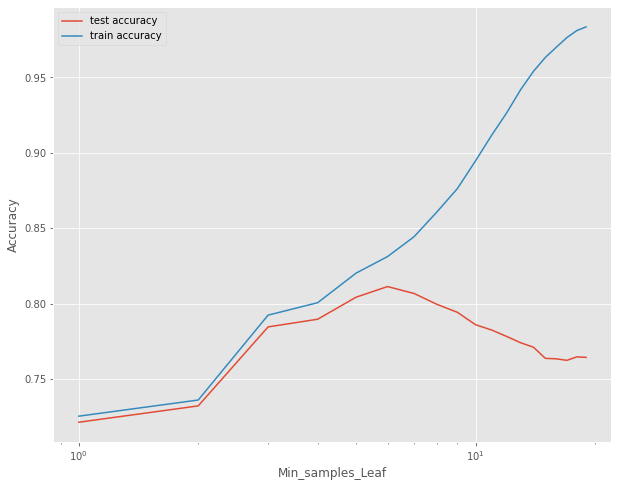

In [207]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_d['param_max_depth'] , cv_results_d['mean_test_score'])
plt.plot(cv_results_d['param_max_depth'] , cv_results_d['mean_train_score'])
plt.xlabel('Min_samples_Leaf')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [208]:
print(tree_split.best_params_)
print(tree_ml.best_params_)
print(tree_d.best_params_)

{'min_samples_split': 180}
{'min_samples_leaf': 19}
{'max_depth': 6}


In [209]:
dt = DecisionTreeClassifier(max_depth = 6 , min_samples_leaf = 19 , min_samples_split = 180)
dt.fit(X_train , y_train)


y_pred_dt = dt.predict(X_test)

ac = accuracy_score(y_test , y_pred_dt)
print(ac*100)

81.81221273801708


In [0]:
# test_pred = xg_model.predict(Test)

# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission05xgb.csv', index=False)

***Test Data Report***
Best max_depth =  6
Best min_samples_split =  180
AUC =  78.89811685348393


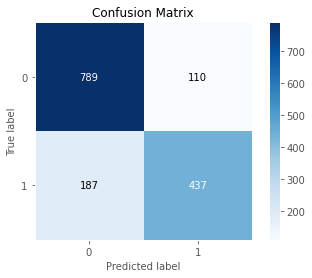

In [211]:
optimal_depth = 6
optimal_split = 180

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best min_samples_split = ",optimal_split)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

## Random Forest on Response-Encdoing

In [212]:
max_depths = [2,4,6,9,11]
base_learners = [1, 5, 10, 50, 100]
param_grid = {'max_depth': max_depths,'n_estimators':base_learners}


model = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1 , return_train_score = True)
model.fit(X_train, y_train)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Model with best parameters :
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy of the model :  0.951185648382789


In [213]:
y_pred_rf = model.predict(X_test)
ac = accuracy_score(y_test , y_pred_rf)
ac

0.8220617202889035

In [214]:
dataframe = pd.DataFrame(model.cv_results_)
dataframe.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.011755,0.001626,0.003249,0.000374,2,1,"{'max_depth': 2, 'n_estimators': 1}",0.585674,0.579342,0.565752,0.576923,0.008311,25,0.570010,0.580964,0.588094,0.579689,0.007438
1,0.030907,0.001853,0.004176,0.000203,2,5,"{'max_depth': 2, 'n_estimators': 5}",0.824017,0.764259,0.831771,0.806682,0.030164,21,0.830751,0.787004,0.836521,0.818092,0.022108
2,0.054483,0.001401,0.005955,0.000272,2,10,"{'max_depth': 2, 'n_estimators': 10}",0.813843,0.821261,0.818447,0.817850,0.003058,19,0.817655,0.841804,0.823007,0.827489,0.010356
3,0.259136,0.003466,0.015887,0.000587,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.839360,0.809021,0.839277,0.829219,0.014283,18,0.849301,0.829423,0.840137,0.839620,0.008123
4,0.517235,0.015496,0.028001,0.000722,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.842033,0.822414,0.842974,0.835807,0.009478,17,0.849331,0.843905,0.843550,0.845596,0.002646


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



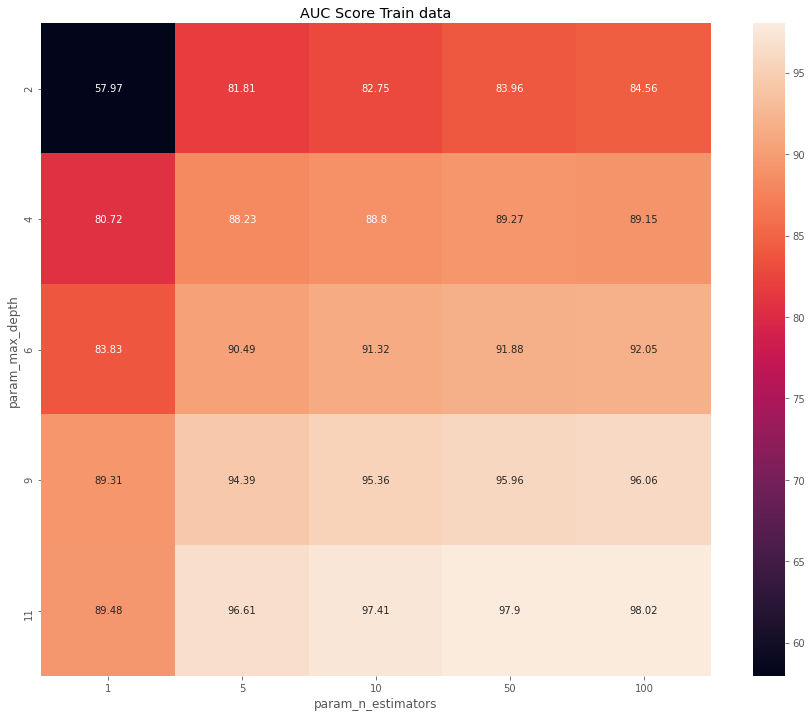

In [215]:
# Train Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize = (15 , 12))
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('AUC Score Train data')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



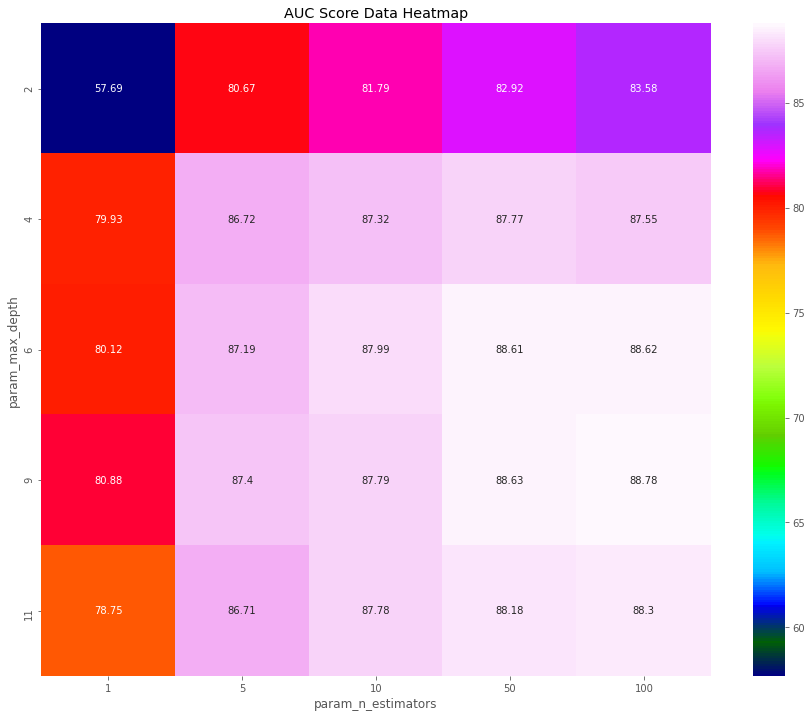

In [216]:
# CV Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize = (15 , 12))
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g' , cmap = 'gist_ncar')
ax = plt.axes()
ax.set_title('AUC Score Data Heatmap')
plt.show()

***Test Data Report***
Best max_depth =  9
Best Base Learners =  150
AUC =  81.74128661475713


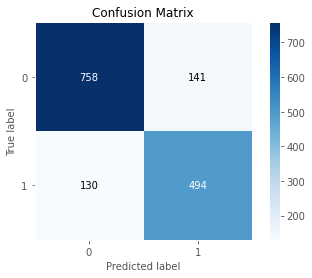

In [217]:
optimal_depth = 9
optimal_estimators = 150

lr = RandomForestClassifier(n_estimators=optimal_estimators, max_depth=optimal_depth, class_weight='balanced')
lr.fit(X_train , y_train)
pred = lr.predict(X_test)

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best Base Learners = ",optimal_estimators)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [0]:
# test_pred = xg_model.predict(Test)

# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission05xgb.csv', index=False)

In [219]:
rf = RandomForestClassifier()
rf.fit(X_train , y_train)

y_pred_rf = rf.predict(X_test)

ac_rf = accuracy_score(y_test , y_pred_rf)
print(ac_rf*100)

78.92317793827971


In [220]:
n_folds = 10
parameters = {'max_depth': range(2, 30, 2)}

rf = RandomForestClassifier(random_state = 100)
grd_search_max = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)

grd_search_max.fit(X_train , y_train)
print('Best parameter for max_depth: ',grd_search_max.best_params_)

scores = grd_search_max.cv_results_
pd.DataFrame(scores).head()

Best parameter for max_depth:  {'max_depth': 8}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.640647,0.008367,0.017511,0.001193,2,{'max_depth': 2},0.781609,0.768473,0.763547,0.737274,0.761905,0.725780,0.753695,0.781609,0.740558,0.761905,0.757635,0.017535,14,0.763182,0.763182,0.775223,0.759350,0.767561,0.765736,0.768108,0.776318,0.759715,0.768108,0.766648,0.005462
1,0.957609,0.007646,0.019464,0.001079,4,{'max_depth': 4},0.799672,0.781609,0.791461,0.775041,0.791461,0.775041,0.806240,0.809524,0.798030,0.804598,0.793268,0.011964,13,0.805327,0.805327,0.796752,0.801314,0.800401,0.804415,0.801496,0.803685,0.801861,0.805875,0.802646,0.002693
2,1.210793,0.008420,0.019793,0.001042,6,{'max_depth': 6},0.809524,0.807882,0.825944,0.798030,0.824302,0.821018,0.821018,0.825944,0.822660,0.809524,0.816585,0.009114,3,0.837621,0.833789,0.832147,0.835614,0.831600,0.830323,0.835796,0.831965,0.831783,0.834519,0.833516,0.002206
3,1.456515,0.024534,0.021809,0.001036,8,{'max_depth': 8},0.807882,0.817734,0.827586,0.804598,0.829228,0.829228,0.817734,0.829228,0.834154,0.824302,0.822167,0.009377,1,0.854589,0.852399,0.850392,0.858785,0.851305,0.851669,0.854224,0.852034,0.851669,0.855866,0.853293,0.002436
4,1.623255,0.017664,0.023402,0.001871,10,{'max_depth': 10},0.798030,0.812808,0.827586,0.801314,0.827586,0.819376,0.819376,0.837438,0.821018,0.814450,0.817898,0.011363,2,0.883233,0.883780,0.882138,0.883598,0.883233,0.881773,0.886517,0.883780,0.883963,0.885422,0.883744,0.001325


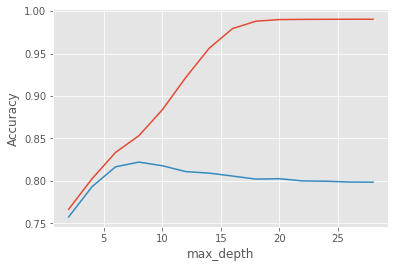

In [221]:
plt.figure()
plt.plot(scores["param_max_depth"],scores["mean_train_score"],label="Training accuracy")
plt.plot(scores["param_max_depth"],scores["mean_test_score"],label="Test accuracy")
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()


In [222]:
n_folds = 5
parameters = {'n_estimators': range(50, 500, 50)}

rf = RandomForestClassifier(random_state = 100)
grd_search_est = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)

grd_search_est.fit(X_train, y_train)
print('Best parameter for n_estimators: ',grd_search_est.best_params_)

scores_1 = grd_search_est.cv_results_
pd.DataFrame(scores_1).head()

Best parameter for n_estimators:  {'n_estimators': 150}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.871135,0.009151,0.020820,0.002247,50,{'n_estimators': 50},0.791461,0.792282,0.794745,0.807061,0.797209,0.796552,0.005626,9,0.990353,0.990764,0.988711,0.989943,0.989943,0.989943,0.000687
1,1.745359,0.017841,0.037305,0.000257,100,{'n_estimators': 100},0.798851,0.789819,0.800493,0.804598,0.802135,0.799179,0.005050,7,0.991174,0.991995,0.990148,0.991174,0.990558,0.991010,0.000628
2,2.659732,0.037115,0.056242,0.000898,150,{'n_estimators': 150},0.795567,0.798030,0.802135,0.805419,0.802956,0.800821,0.003545,1,0.991174,0.992200,0.990148,0.991174,0.990558,0.991051,0.000694
3,3.484769,0.036346,0.073274,0.000977,200,{'n_estimators': 200},0.793103,0.795567,0.802956,0.805419,0.802956,0.800000,0.004776,3,0.991174,0.992406,0.990148,0.991174,0.990558,0.991092,0.000764
4,4.347619,0.056927,0.092266,0.001378,250,{'n_estimators': 250},0.789819,0.793924,0.801314,0.806240,0.805419,0.799343,0.006456,6,0.991174,0.992406,0.990148,0.991174,0.990558,0.991092,0.000764


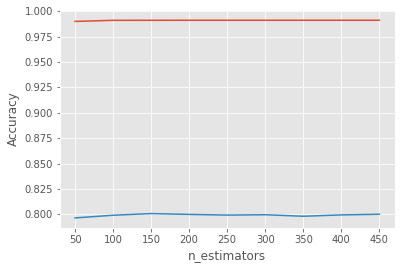

In [223]:
plt.figure()
plt.plot(scores_1["param_n_estimators"],scores_1["mean_train_score"],label="Training accuracy")
plt.plot(scores_1["param_n_estimators"],scores_1["mean_test_score"],label="Test accuracy")
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()

In [224]:
n_folds = 5
parameters = {'min_samples_leaf': range(30, 400, 50)}

rf = RandomForestClassifier(random_state = 100)
grd_search_lf = GridSearchCV(rf , parameters , cv = n_folds , return_train_score = True)

grd_search_lf.fit(X_train, y_train)
print('Best parameter for min_samples_leaf: ',grd_search_lf.best_params_)

scores_2 = grd_search_lf.cv_results_
pd.DataFrame(scores_2).head()

Best parameter for min_samples_leaf:  {'min_samples_leaf': 30}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.765381,0.009442,0.020155,0.001003,30,{'min_samples_leaf': 30},0.806240,0.816913,0.820197,0.825123,0.816092,0.816913,0.006209,1,0.832923,0.835181,0.832512,0.833333,0.834154,0.833621,0.000950
1,0.641301,0.006276,0.018017,0.001771,80,{'min_samples_leaf': 80},0.804598,0.807882,0.810345,0.815271,0.811987,0.810016,0.003620,2,0.823071,0.819787,0.817939,0.819787,0.822044,0.820525,0.001820
2,0.573768,0.009888,0.016356,0.000274,130,{'min_samples_leaf': 130},0.798851,0.795567,0.801314,0.806240,0.804598,0.801314,0.003851,3,0.812603,0.813629,0.808703,0.811166,0.814450,0.812110,0.002026
3,0.540354,0.013083,0.016172,0.000314,180,{'min_samples_leaf': 180},0.789819,0.781609,0.792282,0.804598,0.806240,0.794910,0.009295,4,0.801929,0.804803,0.795977,0.803161,0.805008,0.802176,0.003298
4,0.502712,0.012157,0.015190,0.000544,230,{'min_samples_leaf': 230},0.786535,0.768473,0.770936,0.804598,0.782430,0.782594,0.012923,5,0.798440,0.784893,0.785714,0.796593,0.793309,0.791790,0.005551


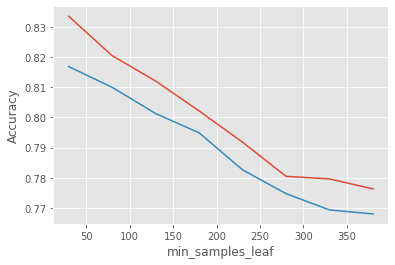

In [225]:
plt.figure()
plt.plot(scores_2["param_min_samples_leaf"],scores_2["mean_train_score"],label="Training accuracy")
plt.plot(scores_2["param_min_samples_leaf"],scores_2["mean_test_score"],label="Test accuracy")
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.show()

In [226]:
n_folds = 5
parameters = {'min_samples_split': range(10, 400, 50)}

rf = RandomForestClassifier()
grd_search_sp = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1, return_train_score = True)

grd_search_sp.fit(X_train, y_train)
print('Best parameter for min_samples_split: ',grd_search_sp.best_params_)

score_3 = grd_search_sp.cv_results_
pd.DataFrame(score_3).head()

Best parameter for min_samples_split:  {'min_samples_split': 60}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.693277,0.023851,0.035720,0.000930,10,{'min_samples_split': 10},0.801314,0.804598,0.812808,0.821018,0.809524,0.809852,0.006842,6,0.929803,0.929598,0.924877,0.928366,0.927750,0.928079,0.001773
1,1.461486,0.014609,0.029992,0.000703,60,{'min_samples_split': 60},0.807882,0.809524,0.823481,0.821839,0.825123,0.817570,0.007332,1,0.850985,0.855501,0.851806,0.851601,0.848112,0.851601,0.002358
2,1.314171,0.012620,0.027088,0.000405,110,{'min_samples_split': 110},0.806240,0.814450,0.816913,0.820197,0.815271,0.814614,0.004627,2,0.836823,0.839080,0.835386,0.831897,0.835386,0.835714,0.002339
3,1.210500,0.014904,0.027527,0.001030,160,{'min_samples_split': 160},0.806240,0.805419,0.815271,0.824302,0.816092,0.813465,0.006994,3,0.829639,0.829433,0.830049,0.828202,0.829228,0.829310,0.000617
4,1.144517,0.012423,0.028646,0.003781,210,{'min_samples_split': 210},0.805419,0.802956,0.810345,0.821018,0.810345,0.810016,0.006201,5,0.824302,0.824918,0.821839,0.826765,0.826970,0.824959,0.001870


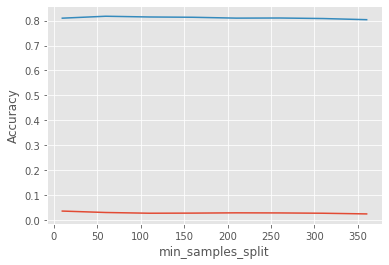

In [232]:
plt.figure()
plt.plot(score_3["param_min_samples_split"],score_3["mean_score_time"],label="Training accuracy")
plt.plot(score_3["param_min_samples_split"],score_3["mean_test_score"],label="Test accuracy")
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.show()

In [233]:
print('Best parameter for max_depth: ',grd_search_max.best_params_)
print('Best parameter for min_samples_leaf: ',grd_search_lf.best_params_)
print('Best parameter for min_samples_split: ',grd_search_sp.best_params_)
print('Best parameter for n_estimators: ',grd_search_est.best_params_)

Best parameter for max_depth:  {'max_depth': 8}
Best parameter for min_samples_leaf:  {'min_samples_leaf': 30}
Best parameter for min_samples_split:  {'min_samples_split': 60}
Best parameter for n_estimators:  {'n_estimators': 150}


In [234]:
# new_rf = RandomForestClassifier(n_estimators = 350 , max_depth = 28 , min_samples_leaf = 30 , min_samples_split = 160)
new_rf = RandomForestClassifier(n_estimators = 350 , max_depth = 8 , min_samples_leaf = 30 , min_samples_split = 60)
new_rf.fit(X_train , y_train)

y_pred_rf = new_rf.predict(X_test)

ac_rf = accuracy_score(y_test , y_pred_rf)
print(ac_rf*100)

82.33749179251477


In [0]:
# test_pred = xg_model.predict(Test)

# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission05xgb.csv', index=False)

## GBDT on Response-Encdoing

In [0]:
learn_rate = {'learning_rate': [0.001 , 0.01 , 0.1 , 1.0 , 1.3]}
folds = 5

In [236]:
GBC = GradientBoostingClassifier()

grd_search_lr = GridSearchCV(GBC , cv = folds , param_grid = learn_rate , n_jobs = -1)
grd_search_lr.fit(X_train, y_train)
print('Best parameter for max_depth: ' , grd_search_lr.best_params_)

cv_results_gbdt = pd.DataFrame(grd_search_lr.cv_results_)
cv_results_gbdt.head()

Best parameter for max_depth:  {'learning_rate': 0.1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.303662,0.013112,0.004490,0.000108,0.001,{'learning_rate': 0.001},0.565681,0.565681,0.565681,0.564860,0.564860,0.565353,0.000402,5
1,2.309302,0.012990,0.005494,0.001210,0.01,{'learning_rate': 0.01},0.790640,0.793924,0.776683,0.807061,0.796388,0.792939,0.009817,2
2,2.388684,0.021874,0.004155,0.000116,0.1,{'learning_rate': 0.1},0.813629,0.815271,0.819376,0.823481,0.818555,0.818062,0.003429,1
3,2.407265,0.010353,0.003446,0.000082,1,{'learning_rate': 1.0},0.788177,0.777504,0.793103,0.803777,0.785714,0.789655,0.008680,3
4,2.234398,0.335922,0.003434,0.000455,1.3,{'learning_rate': 1.3},0.781609,0.766831,0.788177,0.788177,0.782430,0.781445,0.007813,4


In [0]:
sub_sample = {"subsample": [0.3, 0.6, 0.9]}
folds = 5

In [238]:
GBC = GradientBoostingClassifier(max_depth=2, n_estimators=200)

grd_search_ss = GridSearchCV(GBC , cv = folds , param_grid = sub_sample)
grd_search_ss.fit(X_train, y_train)
print('Best parameter for max_depth: ',grd_search_ss.best_params_)

cv_results_sub = pd.DataFrame(grd_search_lr.cv_results_)
cv_results_sub.head()

Best parameter for max_depth:  {'subsample': 0.9}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.303662,0.013112,0.004490,0.000108,0.001,{'learning_rate': 0.001},0.565681,0.565681,0.565681,0.564860,0.564860,0.565353,0.000402,5
1,2.309302,0.012990,0.005494,0.001210,0.01,{'learning_rate': 0.01},0.790640,0.793924,0.776683,0.807061,0.796388,0.792939,0.009817,2
2,2.388684,0.021874,0.004155,0.000116,0.1,{'learning_rate': 0.1},0.813629,0.815271,0.819376,0.823481,0.818555,0.818062,0.003429,1
3,2.407265,0.010353,0.003446,0.000082,1,{'learning_rate': 1.0},0.788177,0.777504,0.793103,0.803777,0.785714,0.789655,0.008680,3
4,2.234398,0.335922,0.003434,0.000455,1.3,{'learning_rate': 1.3},0.781609,0.766831,0.788177,0.788177,0.782430,0.781445,0.007813,4


In [239]:
#GBC = GradientBoostingClassifier(subsample = 0.6 , learning_rate = 0.1 , n_estimators=50 , max_features = 8 , min_samples_leaf = 30 , min_samples_split = 10)

GBC = GradientBoostingClassifier(subsample = 0.9 , learning_rate = 0.1)
GBC.fit(X_train , y_train)

y_gbr = GBC.predict(X_test)

ac_gbr = accuracy_score(y_test , y_gbr)
print(ac_gbr*100)

82.9940906106369


## XGB on Response-Encdoing

In [240]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

ac_xg = accuracy_score(y_test , y_pred)
print(ac_xg*100)

82.79711096520026


In [241]:
max_depths = [2,4,6,9,11]
base_learners = [1, 5, 10, 50, 100]
param_grid = {'max_depth': max_depths,'n_estimators':base_learners}

model = GridSearchCV(xgb.XGBClassifier(scale_pos_weight=1), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1 , return_train_score = True) 
model.fit(X_train, y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Model with best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Accuracy of the model :  0.9087729783803826


***Test Data Report***
Best max_depth =  2
Best Base Learners =  50
AUC =  81.74128661475713


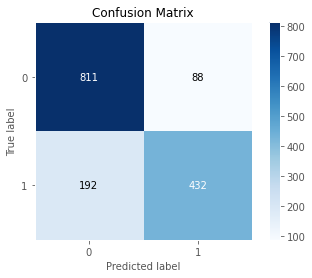

In [242]:
optimal_depth = 2
optimal_estimators = 50

xg_model = xgb.XGBClassifier(max_depth=optimal_depth, n_estimators=optimal_estimators, scale_pos_weight=1)
xg_model.fit(X_train,y_train)

pred = xg_model.predict(X_test)

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best Base Learners = ",optimal_estimators)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [0]:
# test_pred = xg_model.predict(Test)

# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission05xgb.csv', index=False)

In [0]:
### Apply ANN

In [0]:
import tensorflow as tf
from sklearn.metrics import accuracy_score , confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Dense

In [0]:
classifier = Sequential()

In [249]:
classifier.add(Dense(output_dim = 5 , init = 'uniform' , activation = 'relu' , input_dim = 9))
classifier.add(Dense(output_dim = 3 , init = 'uniform' , activation = 'relu'))
classifier.add(Dense(output_dim = 2 , init = 'uniform' , activation = 'relu'))

classifier.add(Dense(output_dim = 1 , init = 'uniform' , activation = 'sigmoid'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=9, units=5, kernel_initializer="uniform")`

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=3, kernel_initializer="uniform")`

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=2, kernel_initializer="uniform")`

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`



In [0]:
classifier.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [251]:
classifier.fit(X_train , y_train , batch_size = 10 , epochs = 200)

Epoch 1/200
6090/6090 [==============================] - 3s 411us/step - loss: 0.6876 - acc: 0.5650
Epoch 2/200
6090/6090 [==============================] - 2s 357us/step - loss: 0.6796 - acc: 0.5654
Epoch 3/200
6090/6090 [==============================] - 2s 354us/step - loss: 0.6658 - acc: 0.5654
Epoch 4/200
6090/6090 [==============================] - 2s 365us/step - loss: 0.6389 - acc: 0.6112
Epoch 5/200
6090/6090 [==============================] - 2s 356us/step - loss: 0.5991 - acc: 0.7126
Epoch 6/200
6090/6090 [==============================] - 2s 363us/step - loss: 0.5553 - acc: 0.7589
Epoch 7/200
6090/6090 [==============================] - 2s 360us/step - loss: 0.5146 - acc: 0.7857
Epoch 8/200
6090/6090 [==============================] - 2s 363us/step - loss: 0.4860 - acc: 0.7987
Epoch 9/200
6090/6090 [==============================] - 2s 362us/step - loss: 0.4656 - acc: 0.8082
Epoch 10/200
6090/6090 [==============================] - 2s 364us/step - loss: 0.4531 - acc: 0.8099

In [0]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

In [261]:
y_pred[:20]

array([[False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False]])